In [14]:
import numpy as np
import cv2
import cv2.aruco as aruco
from PIL import Image
import matplotlib.pyplot as plt


In [76]:
# Side view
side_view_camera_calibration_dir = "/home/joseph/Documents/project/videos/calibration_images/Moto3G_calibration/"
calibration_file = side_view_camera_calibration_dir + "calibration_data.out.npz"
side_view_folder = "/home/joseph/Documents/project/videos/calibration_images/rotation_calibration/side_view_motog3/"
side_view_image = side_view_folder + "IMG_20220328_233854009.jpg"

In [3]:
npzfile = np.load(calibration_file)

print(sorted(npzfile.files))
print(npzfile['mtx'])
print(npzfile['dist'])
print(npzfile['ret'])

matrix_coefficients = npzfile['mtx']
distortion_coefficients = npzfile['dist']

['dist', 'mtx', 'ret']
[[3.46997260e+03 0.00000000e+00 1.93754366e+03]
 [0.00000000e+00 3.47770950e+03 1.01943319e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 0.03628926  0.51850655 -0.01466579 -0.01775694 -1.2316409 ]]
1.9390609576723874


In [26]:
img_path = side_view_image
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

arucoDict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
arucoParameters =  cv2.aruco.DetectorParameters()
arucoDetector = cv2.aruco.ArucoDetector(arucoDict, arucoParameters)

# lists of ids and the corners beloning to each id
corners, ids, rejected_img_points = arucoDetector.detectMarkers(gray)
annotated_frame = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
aruco.drawDetectedMarkers(annotated_frame, corners)

array([[[ 38,  38,  38],
        [ 41,  41,  41],
        [ 38,  38,  38],
        ...,
        [171, 171, 171],
        [174, 174, 174],
        [172, 172, 172]],

       [[ 36,  36,  36],
        [ 39,  39,  39],
        [ 37,  37,  37],
        ...,
        [168, 168, 168],
        [169, 169, 169],
        [169, 169, 169]],

       [[ 30,  30,  30],
        [ 33,  33,  33],
        [ 32,  32,  32],
        ...,
        [168, 168, 168],
        [166, 166, 166],
        [168, 168, 168]],

       ...,

       [[137, 137, 137],
        [139, 139, 139],
        [139, 139, 139],
        ...,
        [101, 101, 101],
        [ 99,  99,  99],
        [102, 102, 102]],

       [[135, 135, 135],
        [138, 138, 138],
        [137, 137, 137],
        ...,
        [102, 102, 102],
        [ 97,  97,  97],
        [100, 100, 100]],

       [[133, 133, 133],
        [135, 135, 135],
        [135, 135, 135],
        ...,
        [101, 101, 101],
        [ 93,  93,  93],
        [ 96,  96,  96]]

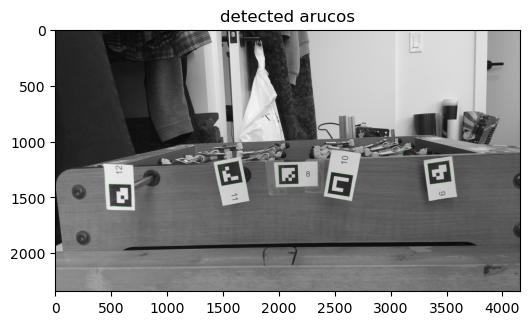

In [28]:
annotated_frame_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
aruco_img = Image.fromarray(annotated_frame_rgb)

plt.figure(figsize=(6, 4))
plt.title("detected arucos")
plt.imshow(aruco_img)

In [29]:
print(ids)

[[12]
 [10]
 [11]
 [ 9]
 [ 8]
 [19]]


In [40]:
print(len(corners))
print(type(corners))
print(len(ids))
print(type(ids))

6
<class 'tuple'>
6
<class 'numpy.ndarray'>
[12]


In [43]:

# corner_id_dict = dict(zip(ids.tolist(), corners))
id_list = ids.flatten()
corner_id_dict = {id_list[i]: corners[i] for i in range(len(ids))}

In [44]:
reference_id = 8
marker_size = 0.02 #m

In [53]:
# get relative rotations with respect to marker 8


# Estimate pose of each marker and return the values rvec and tvec---different from camera coefficients
# rvec, tvec, markerPoints = aruco.estimatePoseSingleMarkers(corner_id_dict[reference_id], marker_size, matrix_coefficients,
#                                                            distortion_coefficients)

objectPoints = np.array([
    [-marker_size / 2, marker_size / 2, 0],
    [ marker_size / 2, marker_size / 2, 0],
    [ marker_size / 2, -marker_size / 2, 0],
    [-marker_size / 2, -marker_size / 2, 0]])

retval_8, rvec_8, tvec_8 = cv.solvePnP(objectPoints, corner_id_dict[reference_id], matrix_coefficients, distortion_coefficients, flags=cv2.SOLVEPNP_IPPE_SQUARE)
# success, rotation_vector, translation_vector = cv2.solvePnP(points_3D, points_2D, camera_matrix, dist_coeffs, flags=0)

In [55]:
print(retval_8)
print(rvec_8 * 180/np.pi)
print(tvec_8)

True
[[-172.55553721]
 [   4.01259617]
 [  12.78819587]]
[[0.01692777]
 [0.03219861]
 [0.39872894]]


In [59]:
# https://aliyasineser.medium.com/calculation-relative-positions-of-aruco-markers-eee9cc4036e3
# https://gist.github.com/aliyasineser/62e3ef99f55c70df1b1df0ccccedab8e#file-python_aruco_relative_tracker-py

def inversePerspective(rvec, tvec):
    R, _ = cv2.Rodrigues(rvec)
    R = np.matrix(R).T
    invTvec = np.dot(-R, np.matrix(tvec))
    invRvec, _ = cv2.Rodrigues(R)
    return invRvec, invTvec


def relativePosition(rvec1, tvec1, rvec2, tvec2):
    """ Get relative position for rvec2 & tvec2. Compose the returned rvec & tvec to use composeRT with rvec2 & tvec2 """
    rvec1, tvec1 = rvec1.reshape((3, 1)), tvec1.reshape((3, 1))
    rvec2, tvec2 = rvec2.reshape((3, 1)), tvec2.reshape((3, 1))
    # Inverse the second marker
    invRvec, invTvec = inversePerspective(rvec2, tvec2)
    info = cv2.composeRT(rvec1, tvec1, invRvec, invTvec)
    composedRvec, composedTvec = info[0], info[1]
    composedRvec = composedRvec.reshape((3, 1))
    composedTvec = composedTvec.reshape((3, 1))
    return composedRvec, composedTvec


In [60]:
retval_12, rvec_12, tvec_12 = cv.solvePnP(objectPoints, corner_id_dict[12], matrix_coefficients, distortion_coefficients, flags=cv2.SOLVEPNP_IPPE_SQUARE)
print(retval_12)
print(rvec_12 * 180/np.pi)
print(tvec_12)

True
[[ 125.06970426]
 [-124.90683166]
 [ -16.87841866]]
[[-0.13388958]
 [ 0.04724767]
 [ 0.35384982]]


In [139]:
r_8_12, t_8_12 = relativePosition(tvec_8, tvec_12, rvec_8, rvec_12)

In [140]:
print(r_8_12 * 180 / np.pi)
print(t_8_12)

[[168.06040073]
 [-37.92124485]
 [ -7.64093984]]
[[-2.46882943]
 [-2.15703103]
 [-0.02770603]]


In [142]:
retval_9, rvec_9, tvec_9 = cv.solvePnP(objectPoints, corner_id_dict[9], matrix_coefficients, distortion_coefficients, flags=cv2.SOLVEPNP_IPPE_SQUARE)

r_8_9, t_8_9 = relativePosition(tvec_8, tvec_9, rvec_8, rvec_9)
print(r_8_9 * 180 / np.pi)
print(t_8_9)

[[168.06040073]
 [-37.92124485]
 [ -7.64093984]]
[[ 2.32735803]
 [-2.19740139]
 [-0.45256663]]


In [71]:
def print_rotation(r):
    print(r * 180 / np.pi)

def get_pose_of_id(aruco_id, corner_dict, marker_size, mtx, dist):
    objectPoints = np.array([
    [-marker_size / 2, marker_size / 2, 0],
    [ marker_size / 2, marker_size / 2, 0],
    [ marker_size / 2, -marker_size / 2, 0],
    [-marker_size / 2, -marker_size / 2, 0]])
    
    retval_1, rvec_1, tvec_1 = cv.solvePnP(objectPoints, corner_dict[aruco_id], mtx, dist, flags=cv2.SOLVEPNP_IPPE_SQUARE)
    return rvec_1

def get_rotation_between_ids(id1, id2, corner_dict, marker_size, mtx, dist):
    objectPoints = np.array([
    [-marker_size / 2, marker_size / 2, 0],
    [ marker_size / 2, marker_size / 2, 0],
    [ marker_size / 2, -marker_size / 2, 0],
    [-marker_size / 2, -marker_size / 2, 0]])
    
    retval_1, rvec_1, tvec_1 = cv.solvePnP(objectPoints, corner_dict[id1], mtx, dist, flags=cv2.SOLVEPNP_IPPE_SQUARE)
    print("r1=")
    print_rotation(rvec_1)
    retval_2, rvec_2, tvec_2 = cv.solvePnP(objectPoints, corner_dict[id2], mtx, dist, flags=cv2.SOLVEPNP_IPPE_SQUARE)
    print("r2=")
    print_rotation(rvec_2)
    r_1_2, t_1_2 = relativePosition(tvec_1, tvec_2, rvec_1, rvec_2)
    return r_1_2, t_1_2


In [144]:
r_8_10, t_8_10 = get_rotation_between_ids(8, 10, corner_id_dict, marker_size, matrix_coefficients, distortion_coefficients)
print_rotation(r_8_10)

r1=
[[-172.55553721]
 [   4.01259617]
 [  12.78819587]]
r2=
[[-135.02958451]
 [ 116.21343508]
 [  16.4322166 ]]
[[168.06040073]
 [-37.92124485]
 [ -7.64093984]]


In [68]:
print_rotation(rvec_12 - rvec_8)

[[ 297.62524146]
 [-128.91942782]
 [ -29.66661453]]


In [72]:
rvec_10 = get_pose_of_id(10, corner_id_dict, marker_size, matrix_coefficients, distortion_coefficients)

In [90]:
print_rotation(rvec_10)
print(rvec_10.shape)

[[-135.02958451]
 [ 116.21343508]
 [  16.4322166 ]]
(3, 1)


In [74]:
print_rotation(rvec_10 - rvec_8)

[[ 37.5259527 ]
 [112.20083892]
 [  3.64402073]]


In [128]:
video_file = side_view_folder + "VID_20220329_032013124.mp4"


In [129]:
capture = cv2.VideoCapture(video_file)

length = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))


In [130]:
fps = capture.get(cv2.CAP_PROP_FPS)
duration = length / fps #seconds

In [131]:
print(length)
print(duration)

1954
66.72175555555556


In [132]:
aruco_id_list = [9, 10, 11, 12]
id_index_dict = {9:0, 10:1, 11:2, 12:3}
rotations = np.zeros((length, 4, 3))

In [133]:
img_idx = 0
aruco_id = 9
while(capture.isOpened()):
    (grabbed, img) = capture.read()
    
    if grabbed == True:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        arucoDict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
        arucoParameters =  cv2.aruco.DetectorParameters()
        arucoDetector = cv2.aruco.ArucoDetector(arucoDict, arucoParameters)
        
        # lists of ids and the corners beloning to each id
        corners, ids, rejected_img_points = arucoDetector.detectMarkers(gray)

        id_list = ids.flatten()
        corner_dict = {id_list[i]: corners[i] for i in range(len(id_list))}
        
        # annotated_frame = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        # aruco.drawDetectedMarkers(annotated_frame, corners)

        for aruco_id in aruco_id_list:
            if aruco_id in id_list:
                rvec = get_pose_of_id(aruco_id, corner_dict, marker_size, matrix_coefficients, distortion_coefficients)
                array_idx = id_index_dict[aruco_id]
                rotations[img_idx, array_idx] = rvec.flatten()
        img_idx+=1
    else:
        break
    
capture.release()

In [134]:
def plot_rotations(aruco_id, rotations, time):
    # PLot
    plt.plot(time, rotations[:,0], label='rot-0')
    plt.plot(time, rotations[:,1], label='rot-1')
    plt.plot(time, rotations[:,2], label='rot-2')
    
    # Add Title
    plt.title(f"Rotations for aruco {aruco_id}") 
    
    # Add Axes Labels
    
    
    plt.xlabel("time") 
    plt.ylabel("rotation") 
    plt.legend()
    # Display
    
    plt.show()
    

In [221]:
def plot_theta(aruco_id, theta, time):
    # PLot
    plt.plot(time, theta * 180 / np.pi, label='theta')
    # Add Title
    plt.title(f"Aruco {aruco_id} theta") 
    
    # Add Axes Labels
    plt.xlabel("time") 
    plt.ylabel("theta") 
    plt.legend()
    # Display
    
    plt.show()

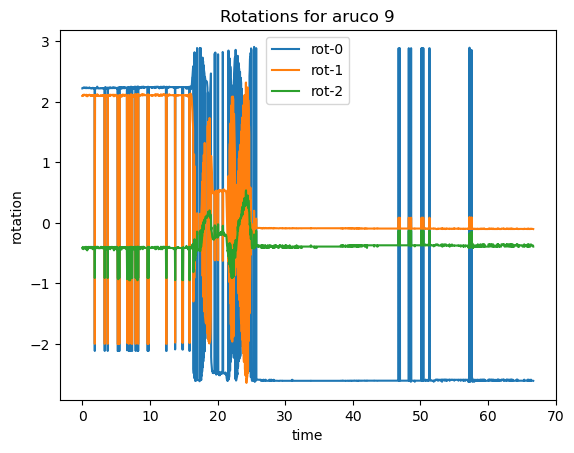

In [135]:
# Data Coordinates
time = np.arange(0, length) * 1 / fps
plt.close("all")
plot_rotations(9, rotations[:,id_index_dict[9],:], time)

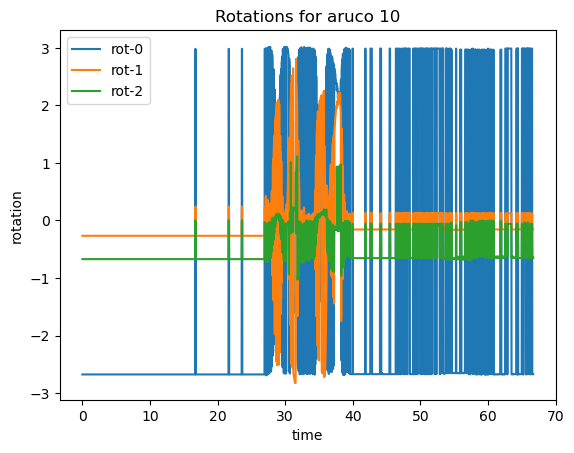

In [136]:
plt.close("all")
plot_rotations(10, rotations[:,id_index_dict[10],:], time)

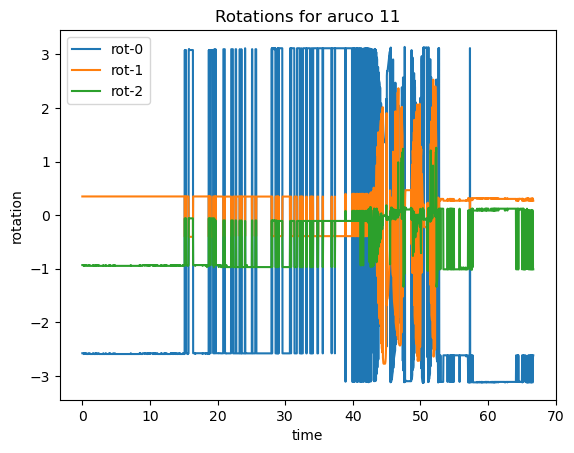

In [137]:
plt.close("all")
plot_rotations(11, rotations[:,id_index_dict[11],:], time)

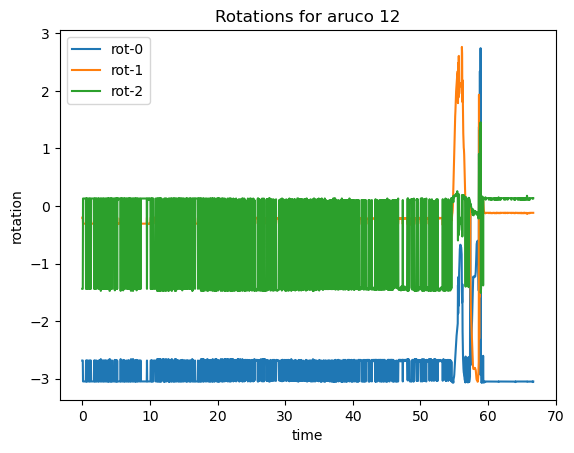

In [138]:
plt.close("all")
plot_rotations(12, rotations[:,id_index_dict[12],:], time)

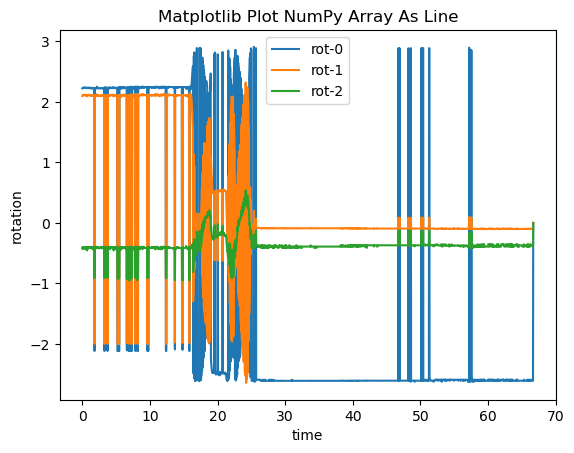

In [108]:
# Data Coordinates
x = np.arange(0, length) * 1 / fps

# PLot
plt.plot(x, rotations[:,0, 0], label='rot-0')
plt.plot(x, rotations[:,0, 1], label='rot-1')
plt.plot(x, rotations[:,0, 2], label='rot-2')

# Add Title
plt.title("Matplotlib Plot NumPy Array As Line") 

# Add Axes Labels


plt.xlabel("time") 
plt.ylabel("rotation") 
plt.legend()
# Display

plt.show()

In [147]:
# plt.close("all")


# plot_rotations(9, rotations[:,id_index_dict[9],:], time)
r_23_idx = int(np.round(fps * 23))
r0 = rotations[0,id_index_dict[9]]
r23 = rotations[r_23_idx,id_index_dict[9]]

print("r0=",r0)
print("r23=",r23)

cross = np.cross(r23, r0)
print("cross=",cross)

r0= [ 2.22319238  2.09794141 -0.41773616]
r23= [-2.39565561  0.76575286 -0.12831096]
cross= [-0.05069379 -1.28601193 -6.72836104]


In [153]:
cross_mag = np.linalg.norm(cross)
print("cross_mag=",cross_mag)
theta = np.arcsin(cross_mag/np.linalg.norm(r0)/np.linalg.norm(r23))
print("theta=",theta*180/np.pi)

cross_mag= 6.850345888199214
theta= 61.84695398126105


In [167]:
aruco_9_rotations = rotations[:,id_index_dict[9],:]
aruco_9_cross_products =  np.cross(aruco_9_rotations, r0)
aruco_9_cross_mag = np.linalg.norm(aruco_9_cross_products, axis=1)
aruco_9_theta = np.arcsin(aruco_9_cross_mag/np.linalg.norm(r0)/np.linalg.norm(aruco_9_rotations, axis=1))

In [168]:
print(aruco_9_cross_products.shape)
print(aruco_9_cross_mag.shape)
print(aruco_9_theta.shape)

(1954, 3)
(1954,)
(1954,)


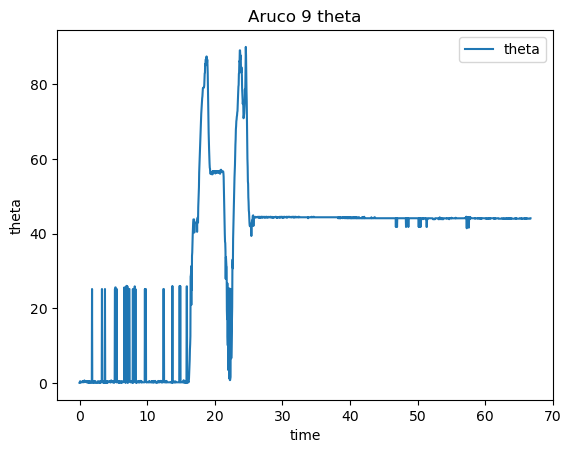

In [169]:
# Data Coordinates
# PLot
plt.close("all")

plt.plot(time, aruco_9_theta * 180 / np.pi, label='theta')

# Add Title
plt.title("Aruco 9 theta") 

# Add Axes Labels
plt.xlabel("time") 
plt.ylabel("theta") 
plt.legend()
# Display

plt.show()

In [181]:
aruco_9_rot_matrice0, _ = cv2.Rodrigues(aruco_9_rotations[0])
print(aruco_9_rot_matrice0)
print(aruco_9_rotations[0])



[[ 0.03929184  0.98687147 -0.15665519]
 [ 0.97160785 -0.07433931 -0.2246149 ]
 [-0.23331167 -0.14338188 -0.961773  ]]
[ 2.22319238  2.09794141 -0.41773616]


In [187]:
from scipy.spatial.transform import Rotation
numpy_rot = Rotation.from_matrix(aruco_9_rot_matrice0)
print(numpy_rot_vec.as_matrix())
print(numpy_rot_vec.as_rotvec())

[[ 0.03929184  0.98687147 -0.15665519]
 [ 0.97160785 -0.07433931 -0.2246149 ]
 [-0.23331167 -0.14338188 -0.961773  ]]
[ 2.22319238  2.09794141 -0.41773616]


In [198]:
numpy_rot_list = Rotation.from_rotvec(aruco_9_rotations)
print(len(numpy_rot_list))
R0 = numpy_rot_list[0]
R0_inv = numpy_rot_list[0].inv()
print((R0 * R0_inv).as_rotvec())

zeroed_rotations = (R0_inv * numpy_rot_list).as_rotvec()
print(zeroed_rotations.shape)

1954
[0. 0. 0.]
(1954, 3)


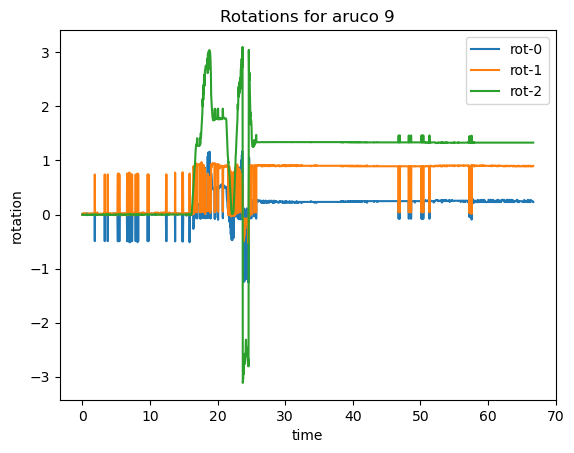

In [200]:
plt.close("all")

plot_rotations(9, zeroed_rotations, time)

1954
[0. 0. 0.]


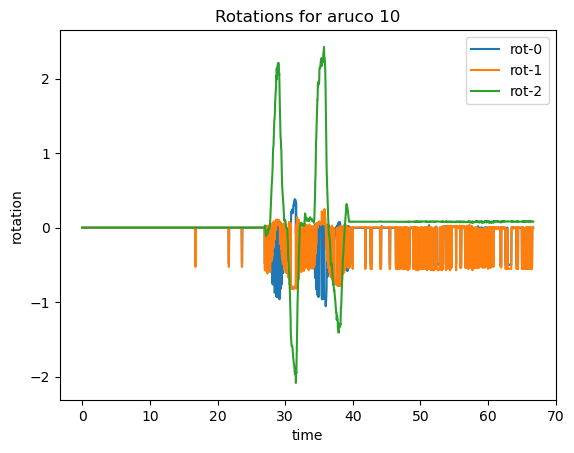

In [202]:
aruco_10_rotations = rotations[:,id_index_dict[10],:]
numpy_rot_list = Rotation.from_rotvec(aruco_10_rotations)
print(len(numpy_rot_list))
R0 = numpy_rot_list[0]
R0_inv = numpy_rot_list[0].inv()
print((R0 * R0_inv).as_rotvec())

zeroed_rotations = (R0_inv * numpy_rot_list).as_rotvec()
plt.close("all")
plot_rotations(10, zeroed_rotations, time)

[[-172.55553721]
 [   4.01259617]
 [  12.78819587]]


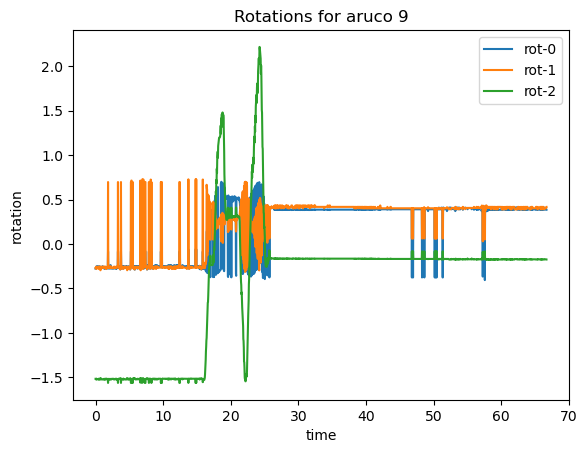

In [224]:
print(rvec_8 * 180/np.pi)
R0_8 = Rotation.from_rotvec(rvec_8.flatten())

numpy_rot_list = Rotation.from_rotvec(aruco_9_rotations)
R0_8_inv = R0_8.inv()
zeroed_rotations = (R0_8_inv * numpy_rot_list).as_rotvec()
plt.close("all")
plot_rotations(9, zeroed_rotations, time)

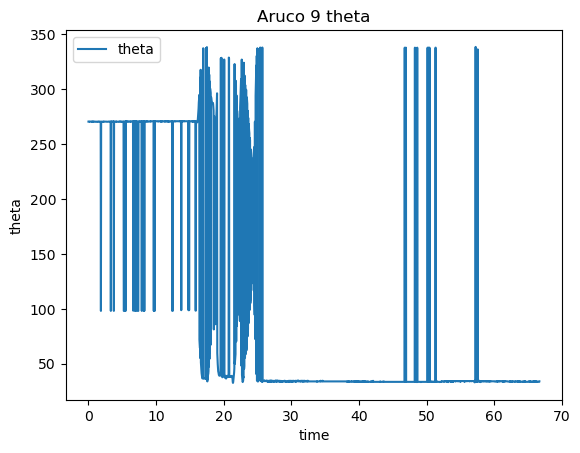

In [218]:
quaternions = (R0_8_inv * numpy_rot_list).as_quat()
# scalar by default is 4th element - ie index 3
w = quaternions[:,3]
theta = np.arccos(w)*2

# Data Coordinates
# PLot
plt.close("all")

plt.plot(time, theta * 180 / np.pi, label='theta')

# Add Title
plt.title("Aruco 9 theta") 

# Add Axes Labels
plt.xlabel("time") 
plt.ylabel("theta") 
plt.legend()
# Display

plt.show()

[-0.99517719  0.02314179  0.07375319  0.06039282]
(1954,)
0.07743996180616017
0.999997905301662
0.36000128753289606


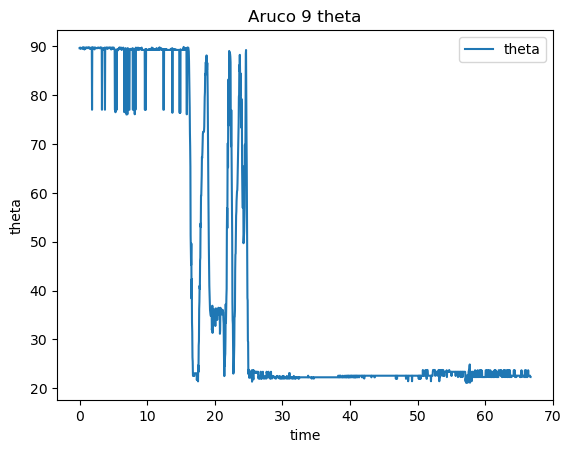

In [231]:
numpy_rot_list = Rotation.from_rotvec(aruco_9_rotations)
zeroed_rotations = (R0_8_inv * numpy_rot_list)

r8_quat = R0_8.as_quat()
print(r8_quat)
[x,y,z,w] = r8_quat
theta = np.arccos(w)*2
n_x = x / np.sin(theta / 2)
n_y = y / np.sin(theta / 2)
n_z = z / np.sin(theta / 2)

norm8 = np.array([n_x, n_y, n_z])
x_axis = np.array([1,0,0 ])
v_ref = np.cross(norm8, x_axis)
v_ref_rotated_0 = R0_8.apply(v_ref)

v_ref_rotated_list = zeroed_rotations.apply(v_ref_rotated_0)
aruco_9_cross_products =  np.cross(v_ref_rotated_list, v_ref_rotated_0)
aruco_9_cross_mag = np.linalg.norm(aruco_9_cross_products, axis=1)
v_ref_rotated_0_mag = np.linalg.norm(v_ref_rotated_0)
v_ref_rotated_list_mags = np.linalg.norm(v_ref_rotated_list, axis=1)

print(v_ref_rotated_list_mags.shape)
print(v_ref_rotated_0_mag)


sin_values = np.divide(aruco_9_cross_mag, v_ref_rotated_list_mags)/v_ref_rotated_0_mag

print(max(sin_values))
print(min(sin_values))

aruco_9_theta = np.arcsin(sin_values)

plt.close("all")
plot_theta(9, aruco_9_theta, time)



In [217]:
r = Rotation.from_matrix(np.eye(3))

r.as_quat()

array([0., 0., 0., 1.])